In [20]:
import os
import json
import pandas as pd

### 1. Loading data

In [21]:
DATA_DIR = '../data/train'

In [22]:
samples = []
bad_files = []

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"XXX ==== Directory not found: {DATA_DIR} ====")

json_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".json")]

for idx, fname in enumerate(json_files):
    fpath = os.path.join(DATA_DIR, fname)
    
    try:
        with open(fpath, "r", encoding="utf-8") as f:
            sample = json.load(f)
    except json.JSONDecodeError as e:
        print(f"[JSON ERROR] File #{idx}: {fname} — {str(e)}")
        bad_files.append({"index": idx, "file": fname, "error": str(e)})
        continue
    except Exception as e:
        print(f"[READ ERROR] File #{idx}: {fname} — {str(e)}")
        bad_files.append({"index": idx, "file": fname, "error": str(e)})
        continue

    desc = sample.get("prob_desc_description", "") or ""
    code = sample.get("source_code", "") or ""
    tags = sample.get("tags", [])

    # Warn if critical fields are missing
    if not desc and not code:
        print(f"[EMPTY FIELDS] File #{idx}: {fname} — missing description/code")
        bad_files.append({"index": idx, "file": fname, "error": "missing text fields"})
        continue

    if not isinstance(tags, list):
        print(f"[INVALID TAGS] File #{idx}: {fname} — tags not a list")
        bad_files.append({"index": idx, "file": fname, "error": "invalid tags"})
        continue

    # Only keep samples with valid tags
    if tags:
        samples.append({
            "text": desc.strip(),
            "code": code.strip(),
            "tags": tags
        })

df = pd.DataFrame(samples)
print(f"==== Loaded {len(df)} valid samples from {DATA_DIR} ====")
print(f"==== Skipped {len(bad_files)} problematic files ====")

if bad_files:
    bad_df = pd.DataFrame(bad_files)
    bad_df.to_csv("bad_files_log.csv", index=False)
    print("Bad file log saved to bad_files_log.csv")


==== Loaded 3459 valid samples from ../data/train ====
==== Skipped 0 problematic files ====


### 2. Quick Overview

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3459 non-null   object
 1   code    3459 non-null   object
 2   tags    3459 non-null   object
dtypes: object(3)
memory usage: 81.2+ KB


In [24]:
df.head(3)

,text,code,tags
0,"There are $$$n$$$ positive integers $$$a_1, a_...",a = int(input())\nfor i in range(a):\n f = ...,"[number theory, greedy]"
1,A positive (strictly greater than zero) intege...,t = int(input())\nfor i in range(t):\n canP...,"[implementation, math]"
2,"Polycarp is working on a new project called ""P...",import sys\nz=x=0\nfor s in sys.stdin:\n\tif s...,[implementation]


In [25]:
df.describe(include='all')

,text,code,tags
count,3459,3459,3459
unique,3459,3459,1454
top,"There are $$$n$$$ positive integers $$$a_1, a_...",a = int(input())\nfor i in range(a):\n f = ...,[implementation]
freq,1,1,195


### 3. Tags Distribution

                        tag  count
1                    greedy   1231
2            implementation   1115
3                      math    976
5   constructive algorithms    718
11                       dp    678
9               brute force    588
18          data structures    539
17                 sortings    477
16            binary search    375
4                    graphs    370


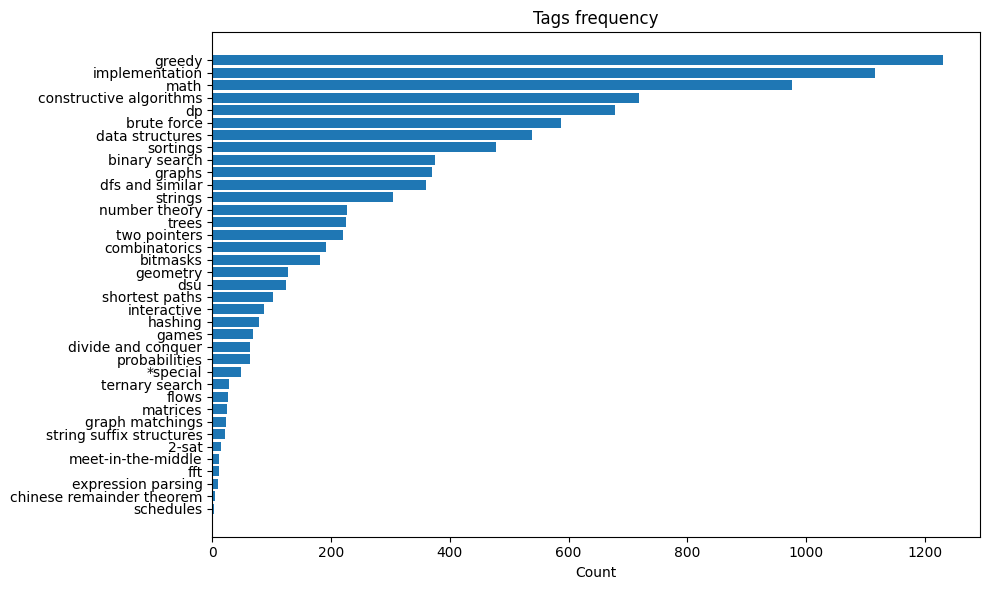

In [39]:
from collections import Counter
import matplotlib.pyplot as plt

# Flatten all tags
all_tags = [t for tags in df["tags"] for t in tags]
tag_counts = Counter(all_tags)

tag_df = pd.DataFrame(tag_counts.items(), columns=["tag", "count"]).sort_values("count", ascending=False)

print(tag_df.head(10))

plt.figure(figsize=(10,6))
plt.barh(tag_df["tag"][::-1], tag_df["count"][::-1])
plt.xlabel("Count")
plt.title("Tags frequency")
plt.tight_layout()
plt.show()

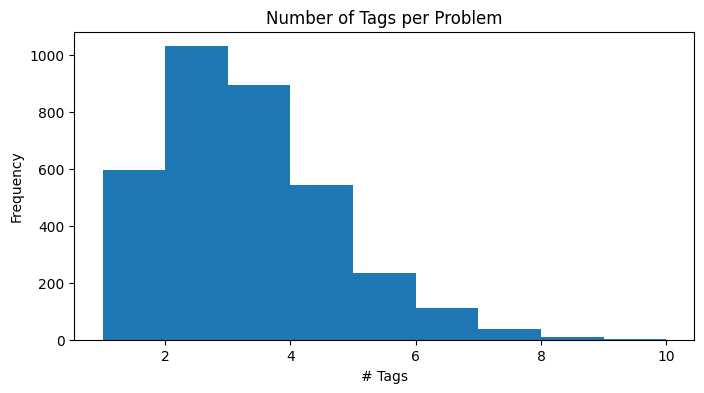

num_tags
1     595
2    1030
3     895
4     542
5     236
6     111
7      39
8       8
9       3
Name: count, dtype: int64


In [40]:
df["num_tags"] = df["tags"].apply(len)

plt.figure(figsize=(8,4))
plt.hist(df["num_tags"], bins=range(1, df["num_tags"].max()+2))
plt.title("Number of Tags per Problem")
plt.xlabel("# Tags")
plt.ylabel("Frequency")
plt.show()

print(df["num_tags"].value_counts().sort_index())

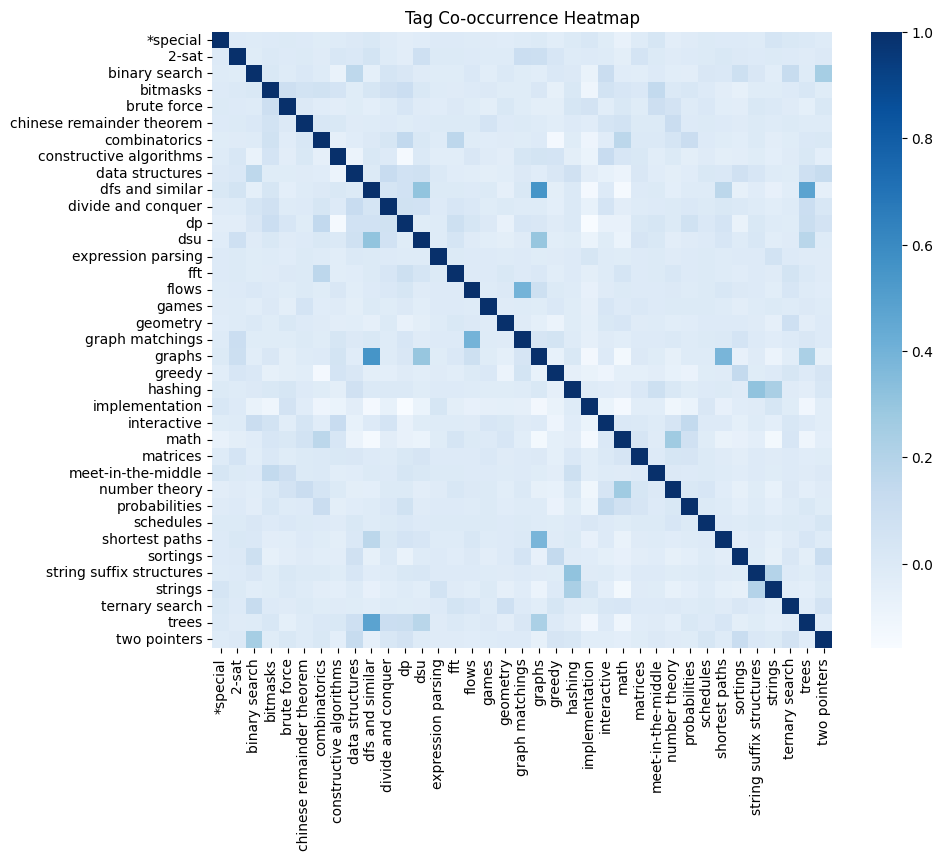

In [41]:
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

mlb = MultiLabelBinarizer()
tag_matrix = pd.DataFrame(mlb.fit_transform(df["tags"]), columns=mlb.classes_)
corr = tag_matrix.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Tag Co-occurrence Heatmap")
plt.show()

### 3. Descriptions & code statistics

       desc_len_chars  desc_len_words
count     3459.000000     3459.000000
mean       946.051749      166.573865
std        443.268512       78.021934
min         63.000000       10.000000
25%        628.500000      111.000000
50%        872.000000      155.000000
75%       1193.000000      210.000000
max       3674.000000      684.000000


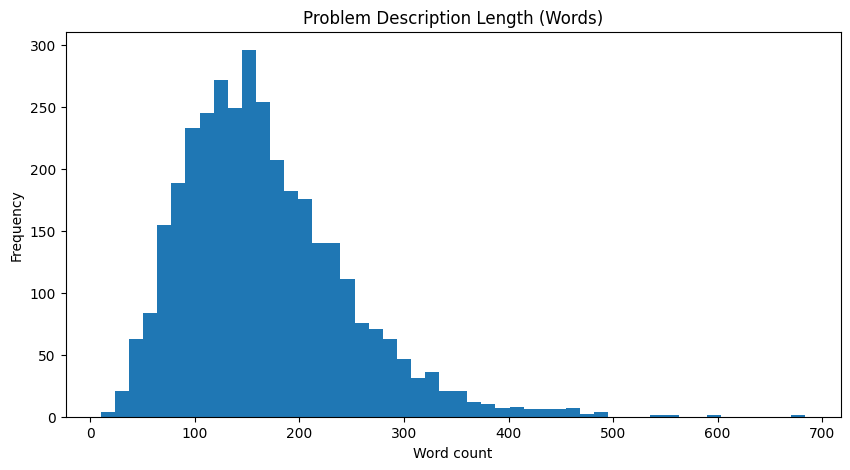

In [27]:
df["desc_len_chars"] = df["text"].apply(len)
df["desc_len_words"] = df["text"].apply(lambda x: len(x.split()))

print(df[["desc_len_chars", "desc_len_words"]].describe())

plt.figure(figsize=(10,5))
plt.hist(df["desc_len_words"], bins=50)
plt.title("Problem Description Length (Words)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

       code_len_chars  code_len_lines
count     3459.000000     3459.000000
mean      1243.862966       50.772767
std       2390.713678       82.391748
min         28.000000        1.000000
25%        357.000000       17.000000
50%        669.000000       31.000000
75%       1315.500000       58.000000
max      58386.000000     2042.000000


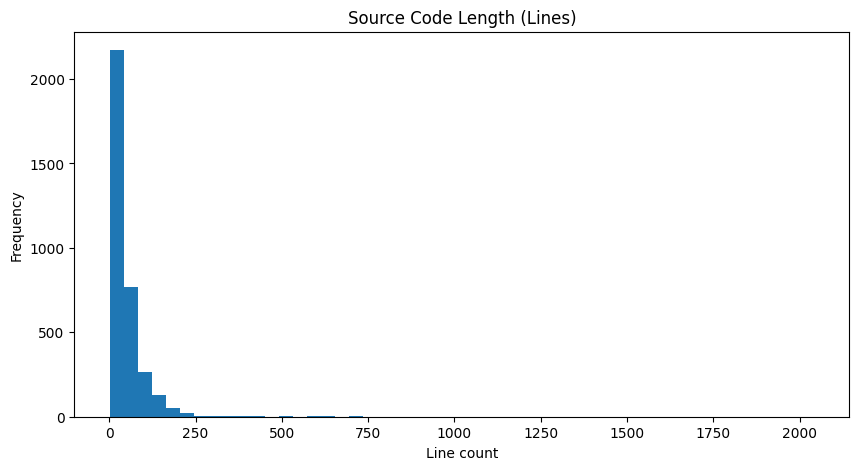

In [28]:
df["code_len_chars"] = df["code"].apply(len)
df["code_len_lines"] = df["code"].apply(lambda x: len(x.split("\n")))

print(df[["code_len_chars", "code_len_lines"]].describe())

plt.figure(figsize=(10,5))
plt.hist(df["code_len_lines"], bins=50)
plt.title("Source Code Length (Lines)")
plt.xlabel("Line count")
plt.ylabel("Frequency")
plt.show()


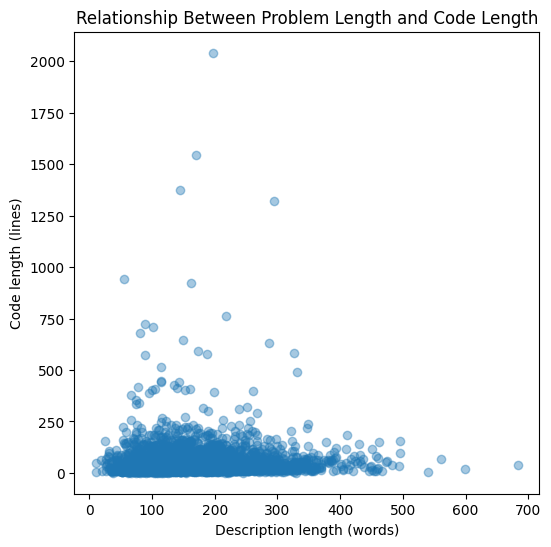

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(df["desc_len_words"], df["code_len_lines"], alpha=0.4)
plt.xlabel("Description length (words)")
plt.ylabel("Code length (lines)")
plt.title("Relationship Between Problem Length and Code Length")
plt.show()


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_text = CountVectorizer(stop_words="english", max_features=30)
X_text = vectorizer_text.fit_transform(df["text"])
top_text_words = zip(vectorizer_text.get_feature_names_out(), X_text.sum(axis=0).A1)
print(" === Top 20 description words:=== \n")
print(sorted(top_text_words, key=lambda x: x[1], reverse=True)[:20])


 === Top 20 description words:=== 

[('number', np.int64(4059)), ('array', np.int64(2027)), ('string', np.int64(1961)), ('given', np.int64(1957)), ('th', np.int64(1711)), ('sequence', np.int64(1447)), ('possible', np.int64(1391)), ('le', np.int64(1323)), ('integers', np.int64(1319)), ('integer', np.int64(1250)), ('length', np.int64(1199)), ('example', np.int64(1165)), ('time', np.int64(1133)), ('numbers', np.int64(1112)), ('following', np.int64(1104)), ('exactly', np.int64(1094)), ('order', np.int64(1086)), ('wants', np.int64(1069)), ('cell', np.int64(1037)), ('equal', np.int64(1018))]


In [44]:
vectorizer_code = CountVectorizer(token_pattern=r"[A-Za-z_]+", max_features=30)
X_code = vectorizer_code.fit_transform(df["code"])
top_code_tokens = zip(vectorizer_code.get_feature_names_out(), X_code.sum(axis=0).A1)
print("=== Top 20 code tokens:=== \n")
print(sorted(top_code_tokens, key=lambda x: x[1], reverse=True)[:20])


=== Top 20 code tokens:=== 

[('i', np.int64(29777)), ('n', np.int64(18687)), ('in', np.int64(17836)), ('if', np.int64(17218)), ('for', np.int64(16281)), ('self', np.int64(16035)), ('a', np.int64(13809)), ('x', np.int64(12823)), ('range', np.int64(10188)), ('print', np.int64(9517)), ('b', np.int64(8911)), ('int', np.int64(8876)), ('j', np.int64(8737)), ('s', np.int64(7745)), ('input', np.int64(7743)), ('def', np.int64(7355)), ('return', np.int64(7267)), ('k', np.int64(6456)), ('l', np.int64(5926)), ('else', np.int64(5500))]


### 4. Summary

In [38]:
summary = {
    "num_samples": len(df),
    "avg_desc_words": df["desc_len_words"].mean(),
    "avg_code_lines": df["code_len_lines"].mean(),
    "avg_tags": df["num_tags"].mean(),
    "top_tags": tag_df.head(10).to_dict(orient="records")
}

import json
with open("eda_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
